# Artificial Intelligence Project 2 - Applied ML

#### Contributor: Dumitrascu Filip-Teodor 333CA

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from scipy.stats import chi2_contingency
from itertools import combinations
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, accuracy_score
)

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neural_network import MLPClassifier
from manual_logistic_regression import ManualLogisticRegression

## Air pollution data set 

### I. EDA (Exploratory Data Analysis)

#### 0. Load csv file

In [2]:
# Load data
airDataFull = pd.read_csv('data/air_pollution_full.csv')

if 'Unnamed: 0' in airDataFull.columns:
    airDataFull = airDataFull.drop(columns=['Unnamed: 0'])

airDataFull.head(n=5)

,Country,City,AQI_Value,AQI_Category,CO_Value,CO_Category,Ozone_Value,Ozone_Category,NO2_Value,NO2_Category,PM25_Value,PM25_Category,VOCs,SO2,Emissions
0,Russian Federation,Praskoveya,51,Moderate,1,Good,36.0,Good,0.0,Good,51,L1,137.467141,10.583998,L1
1,Brazil,Presidente Dutra,41,Good,1,Good,5.0,Good,1.0,Good,41,L0,106.117357,3.415177,L0
2,Italy,Priolo Gargallo,66,Moderate,1,Good,39.0,Good,2.0,Good,66,L1,176.476885,-0.907915,L1
3,Poland,Przasnysz,34,Good,1,Good,34.0,Good,0.0,Good,20,L0,105.230299,3.394132,L0
4,France,Punaauia,22,Good,0,Good,22.0,Good,0.0,Good,6,L0,57.658466,12.458327,L0


#### 1. Analyse the type of attributes and their range of values

##### Attribute types

In [3]:
# split data
numeric_cols_air = airDataFull.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols_air = airDataFull.select_dtypes(include=['object']).columns.tolist()

continuous_features_air = []
ordinal_features_air = []
discrete_features_air = []

# continuous features
for col in numeric_cols_air:
    unique_vals = airDataFull[col].nunique()
    value_range = airDataFull[col].max() - airDataFull[col].min()

    if unique_vals > 20 and value_range > 50:
        continuous_features_air.append(col)
    else:
        discrete_features_air.append(col)

# ordinal features
for col in categorical_cols_air:
    if 'Category' in col or col == 'Emissions':
        ordinal_features_air.append(col)
    else:
        discrete_features_air.append(col)

print("Continuous features:", continuous_features_air)
print("Discrete features:", discrete_features_air)
print("Ordinal features:", ordinal_features_air)

Continuous features: ['AQI_Value', 'CO_Value', 'Ozone_Value', 'NO2_Value', 'PM25_Value', 'VOCs', 'SO2']
Discrete features: ['Country', 'City']
Ordinal features: ['AQI_Category', 'CO_Category', 'Ozone_Category', 'NO2_Category', 'PM25_Category', 'Emissions']


##### Continuous attribute analysis and boxplot

,count,mean,std,min,25%,50%,75%,max
AQI_Value,23463.0,72.010868,56.055220,6.000000,39.000000,55.000000,79.000000,500.000000
CO_Value,23463.0,1.368367,1.832064,0.000000,1.000000,1.000000,1.000000,133.000000
Ozone_Value,21117.0,35.239665,28.149280,0.000000,21.000000,31.000000,40.000000,222.000000
NO2_Value,23463.0,43.084153,196.079179,0.000000,0.000000,1.000000,4.000000,1003.063334
PM25_Value,23463.0,68.519755,54.796443,0.000000,35.000000,54.000000,79.000000,500.000000
VOCs,23463.0,185.053110,140.486759,12.415670,103.267345,142.972272,204.227896,1280.988229
SO2,23463.0,4.447841,5.953601,-18.528019,0.735052,4.286825,7.916001,234.692971


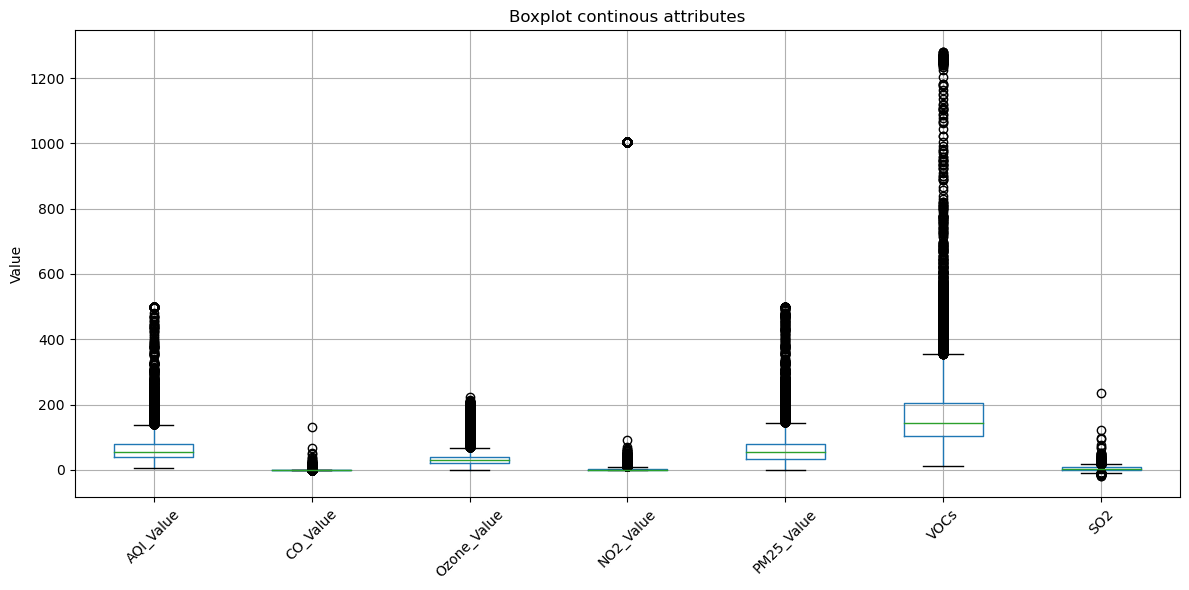

In [4]:
# Description
display(airDataFull[continuous_features_air].describe().T)

# Boxplot config
plt.figure(figsize=(12, 6))
airDataFull[continuous_features_air].boxplot(rot=45)

plt.title("Boxplot continous attributes")
plt.ylabel("Value")

plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig("images/air_polution/boxplot/boxplot_cont_feat_air")
plt.show()

##### Ordinal attribute analysis and histogram

AQI_Category — Number of examples non-null: 23463
AQI_Category — Number of unique values: 6



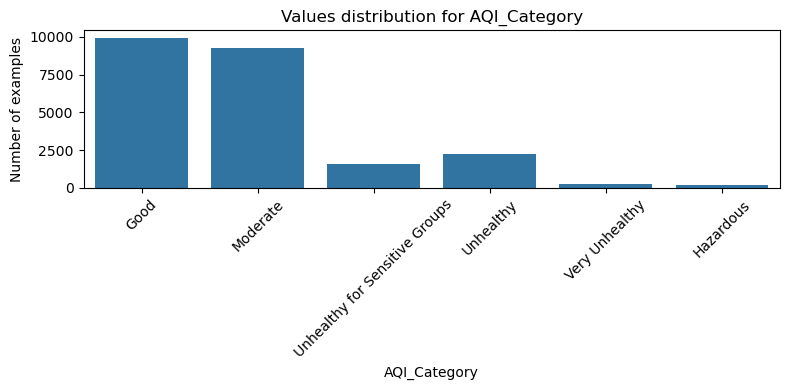

CO_Category — Number of examples non-null: 21117
CO_Category — Number of unique values: 2



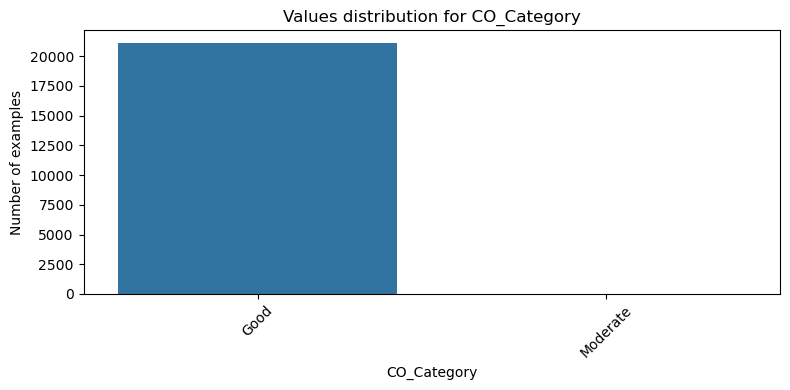

Ozone_Category — Number of examples non-null: 23463
Ozone_Category — Number of unique values: 5



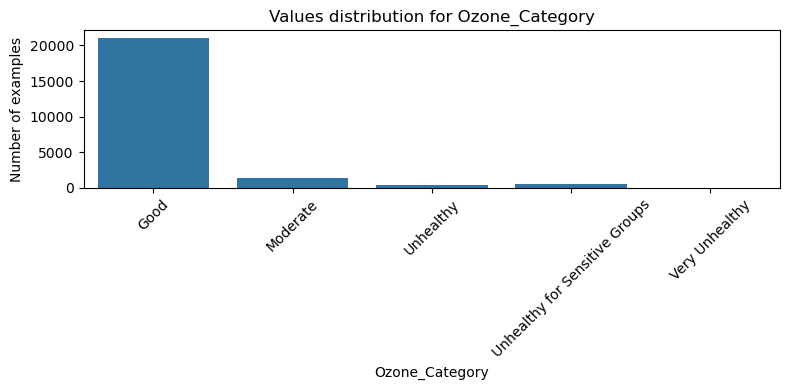

NO2_Category — Number of examples non-null: 23463
NO2_Category — Number of unique values: 2



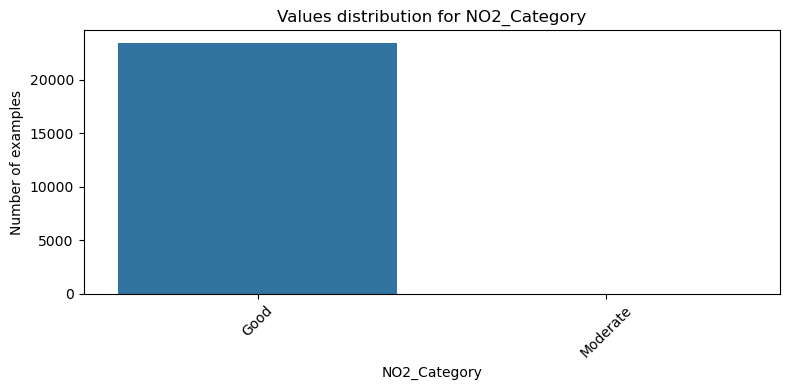

PM25_Category — Number of examples non-null: 23463
PM25_Category — Number of unique values: 6



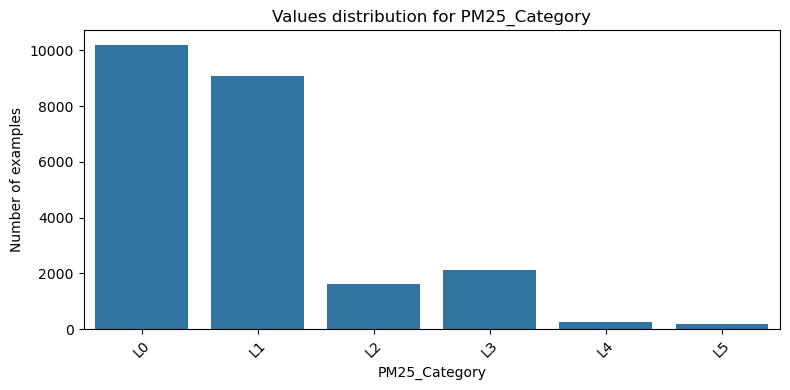

Emissions — Number of examples non-null: 23463
Emissions — Number of unique values: 6



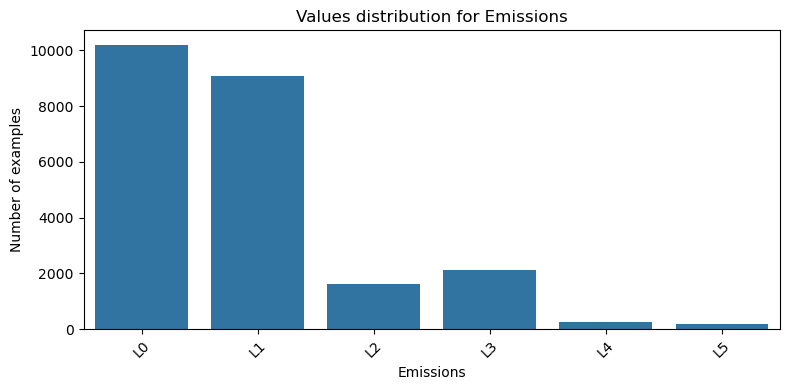

In [5]:
custom_orders_air = {
    'AQI_Category': [
        "Good", "Moderate", "Unhealthy for Sensitive Groups",
        "Unhealthy", "Very Unhealthy", "Hazardous"
    ]
}

l_level_order = ['L0', 'L1', 'L2', 'L3', 'L4', 'L5']


for col in ordinal_features_air:
    if col not in custom_orders_air:
        unique_vals = airDataFull[col].dropna().unique()
        if set(unique_vals).issubset(set(l_level_order)):
            custom_orders_air[col] = l_level_order

summary_data = []

for col in ordinal_features_air:
    non_null_count = airDataFull[col].notna().sum()
    unique_count = airDataFull[col].nunique()

    print(f"{col} — Number of examples non-null: {non_null_count}")
    print(f"{col} — Number of unique values: {unique_count}\n")

    summary_data.append((col, non_null_count, unique_count))
    counts = airDataFull[col].value_counts().sort_index()
    order = custom_orders_air.get(col, counts.index)

    plt.figure(figsize=(8, 4))
    sns.countplot(data=airDataFull, x=col, order=order)
    plt.title(f"Values distribution for {col}")
    plt.xlabel(col)
    plt.ylabel("Number of examples")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"images/air_polution/histogram/ordinal_feat_histogram_{col}")
    plt.show()


#### 2. Class balance analysis

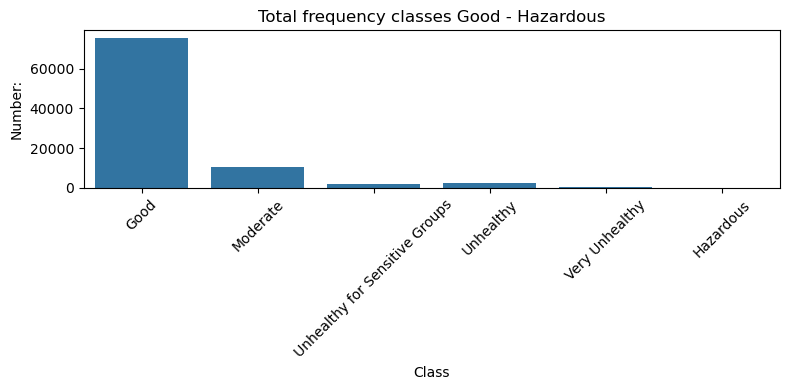

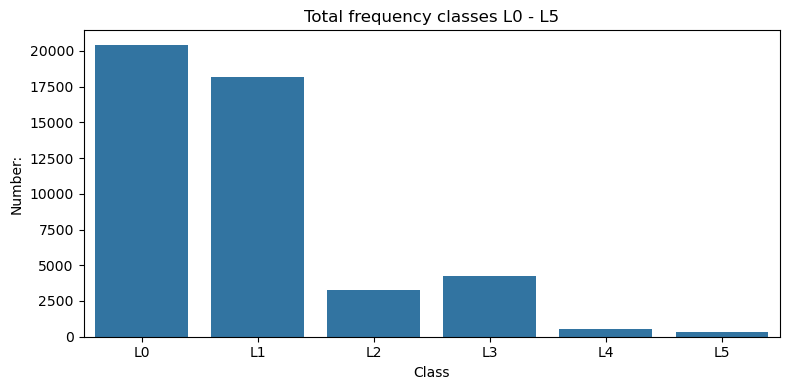

In [6]:
aqi_labels = [
    "Good", "Moderate", "Unhealthy for Sensitive Groups",
    "Unhealthy", "Very Unhealthy", "Hazardous"
]
aqi_counter = Counter()

for col in ordinal_features_air:
    aqi_counter.update(airDataFull[col][airDataFull[col].isin(aqi_labels)])

aqi_df = pd.DataFrame.from_dict(aqi_counter, orient='index', columns=['Frequency'])
aqi_df = aqi_df.reindex(aqi_labels).dropna()

plt.figure(figsize=(8, 4))
sns.barplot(x=aqi_df.index, y=aqi_df['Frequency'])
plt.title("Total frequency classes Good - Hazardous")
plt.xlabel("Class")
plt.ylabel("Number:")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("images/air_polution/boxplot/boxplot_classes_good-hazardous_air")
plt.show()


l_labels = ['L0', 'L1', 'L2', 'L3', 'L4', 'L5']
l_counter = Counter()

for col in ordinal_features_air:
    l_counter.update(airDataFull[col][airDataFull[col].isin(l_labels)])

l_df = pd.DataFrame.from_dict(l_counter, orient='index', columns=['Frequency'])
l_df = l_df.reindex(l_labels).dropna()

plt.figure(figsize=(8, 4))
sns.barplot(x=l_df.index, y=l_df['Frequency'])
plt.title("Total frequency classes L0 - L5")
plt.xlabel("Class")
plt.ylabel("Number:")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("images/air_polution/boxplot/boxplot_classes_l0-l5_air")
plt.show()


#### 3. Corelation between atributes analysis

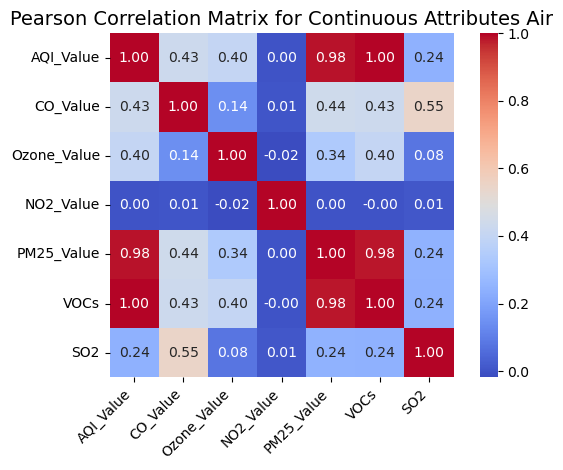

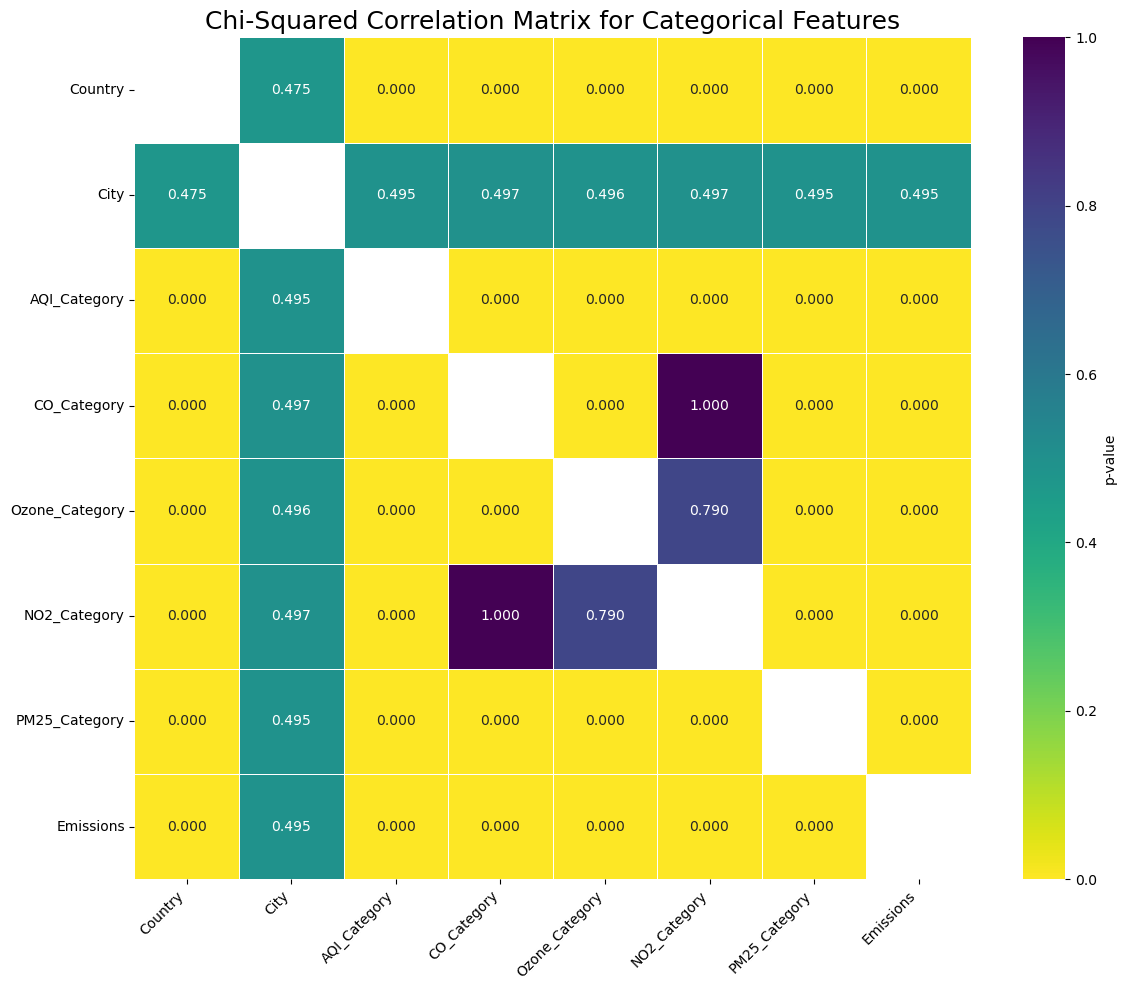

In [7]:
# Continous features correlation_matrix
correlation_matrix_continous = airDataFull[continuous_features_air].corr(method='pearson')

sns.heatmap(correlation_matrix_continous, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)
plt.title("Pearson Correlation Matrix for Continuous Attributes Air", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("images/air_polution/correlation/correlation_cont_matrix")
plt.show()


# Categorical featrues corelation matrix
categorical_features = discrete_features_air + ordinal_features_air
categorical_combinations_air = list(combinations(categorical_features, 2))

chi2_results = [] # (feature1, feature2, p_value)

for var1, var2 in categorical_combinations_air:
    contingency_table = pd.crosstab(airDataFull[var1], airDataFull[var2])
    if contingency_table.shape[0] > 1 and contingency_table.shape[1] > 1:
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        chi2_results.append((var1, var2, p))

pval_matrix = pd.DataFrame(np.nan, index=categorical_features, columns=categorical_features)

for var1, var2, p in chi2_results:
    pval_matrix.loc[var1, var2] = p
    pval_matrix.loc[var2, var1] = p

plt.figure(figsize=(12, 10))
sns.heatmap(
    pval_matrix,
    cmap='viridis_r',
    annot=True,
    fmt=".3f",
    cbar_kws={'label': 'p-value'},
    linewidths=.5
)
plt.title("Chi-Squared Correlation Matrix for Categorical Features", fontsize=18)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("images/air_polution/correlation/correlation_ordinal_matrix")
plt.show()

### II. Data pre-processing

#### 0. Load csv file

In [8]:
# Load data
airDataTrain = pd.read_csv('data/air_pollution_train.csv')
airDataTest = pd.read_csv('data/air_pollution_test.csv')

#### 1. Identification of attributes with missing values

In [9]:
# Number of missing values
missing_train = airDataTrain.isnull().sum()
missing_train = missing_train[missing_train > 0].sort_values(ascending=False)

print("Atributes with missing values:")
display(missing_train)

# Columns
numeric_train_cols = airDataTrain.select_dtypes(include=['float64', 'int64']).columns
categorical_train_cols = airDataTrain.select_dtypes(include=['object']).columns

# Split atrributes with missing values
missing_numeric = [col for col in missing_train.index if col in numeric_train_cols]
missing_categorical = [col for col in missing_train.index if col in categorical_train_cols]

# Simple imputer for numerical using mean
if missing_numeric:
    imputer_numeric = SimpleImputer(strategy='mean')
    airDataTrain[missing_numeric] = imputer_numeric.fit_transform(airDataTrain[missing_numeric])
    airDataTest[missing_numeric] = imputer_numeric.transform(airDataTest[missing_numeric])

# Simple imputer for ordinal using most_frequent
if missing_categorical:
    for col in missing_categorical:
        airDataTrain[col] = airDataTrain[col].astype('object')
        airDataTest[col] = airDataTest[col].astype('object')
    imputer_categorical = SimpleImputer(strategy='most_frequent')
    airDataTrain[missing_categorical] = imputer_categorical.fit_transform(airDataTrain[missing_categorical])
    airDataTest[missing_categorical] = imputer_categorical.transform(airDataTest[missing_categorical])

print("After imputation, missing values in train:")
display(airDataTrain[missing_train.index].isnull().sum())


Atributes with missing values:


CO_Category    1893
Ozone_Value    1870
Country         349
dtype: int64

After imputation, missing values in train:


CO_Category    0
Ozone_Value    0
Country        0
dtype: int64

#### 2. Elimination of attributes with extreme values

In [10]:
# Table to set outliers per column
iqr_bounds = {}

for col in numeric_train_cols:
    # Computes Q1, Q3, IQR on train
    Q1 = airDataTrain[col].quantile(0.25)
    Q3 = airDataTrain[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    iqr_bounds[col] = (lower_bound, upper_bound)

    # Marks outliers on train
    train_outliers_mask = (airDataTrain[col] < lower_bound) | (airDataTrain[col] > upper_bound)
    num_train_outliers = train_outliers_mask.sum()
    airDataTrain.loc[train_outliers_mask, col] = np.nan

    print(f"[Train] {col}: {num_train_outliers} outliers replaced with NaN")

print("\nReplacing outliers with NaN in airDataTest using train IQR...")

for col in numeric_train_cols:
    lower_bound, upper_bound = iqr_bounds[col]

    # Marks outliers in test using train limits
    test_outliers_mask = (airDataTest[col] < lower_bound) | (airDataTest[col] > upper_bound)
    num_test_outliers = test_outliers_mask.sum()
    airDataTest.loc[test_outliers_mask, col] = np.nan

    print(f"[Test] {col}: {num_test_outliers} outliers replaced with NaN")

# Imputes missing values
imputer_outliers = SimpleImputer(strategy='mean')
airDataTrain[numeric_train_cols] = imputer_outliers.fit_transform(airDataTrain[numeric_train_cols])
airDataTest[numeric_train_cols] = imputer_outliers.transform(airDataTest[numeric_train_cols])

print("\nOutliers replaced with NaN and imputed with column mean.")


[Train] AQI_Value: 2354 outliers replaced with NaN
[Train] CO_Value: 6858 outliers replaced with NaN
[Train] Ozone_Value: 1219 outliers replaced with NaN
[Train] NO2_Value: 2038 outliers replaced with NaN
[Train] PM25_Value: 2160 outliers replaced with NaN
[Train] VOCs: 2331 outliers replaced with NaN
[Train] SO2: 240 outliers replaced with NaN

Replacing outliers with NaN in airDataTest using train IQR...
[Test] AQI_Value: 581 outliers replaced with NaN
[Test] CO_Value: 1738 outliers replaced with NaN
[Test] Ozone_Value: 284 outliers replaced with NaN
[Test] NO2_Value: 516 outliers replaced with NaN
[Test] PM25_Value: 547 outliers replaced with NaN
[Test] VOCs: 576 outliers replaced with NaN
[Test] SO2: 56 outliers replaced with NaN

Outliers replaced with NaN and imputed with column mean.


#### 3. Elimination of redundant attributes

In [11]:
# Attributes identified as redundant from the correlation analysis
redundant_continuous = ['VOCs', 'PM25_Value'] # correlation > 0.95
redundant_categorical = [
    'CO_Category', 'Ozone_Category', 'NO2_Category', 'PM25_Category', 'Emissions', # p < 0.05
    'City', 'Country'
]

# Combine them
redundant_features = redundant_continuous + redundant_categorical
print(f"Removed redundant features: {redundant_features}")

# Eliminate from train and test
airDataTrain = airDataTrain.drop(columns=redundant_features, errors='ignore')
airDataTest = airDataTest.drop(columns=redundant_features, errors='ignore')

Removed redundant features: ['VOCs', 'PM25_Value', 'CO_Category', 'Ozone_Category', 'NO2_Category', 'PM25_Category', 'Emissions', 'City', 'Country']


#### 4. Standardization of numerical attribute values

In [12]:
# Numerical atributes after removing redundant and extreme attributes
numeric_cols_removed = airDataTrain.select_dtypes(include=['float64', 'int64']).columns.tolist()

scaler = StandardScaler()

airDataTrain[numeric_cols_removed] = scaler.fit_transform(airDataTrain[numeric_cols_removed])
airDataTest[numeric_cols_removed] = scaler.transform(airDataTest[numeric_cols_removed])

print("Numerical features have been standardized using StandardScaler.")

Numerical features have been standardized using StandardScaler.


### III. ML algorithms

##### Enconding Categorical Attributes

In [13]:
target_column = 'AQI_Category'
categorical_features = airDataTrain.select_dtypes(include='object').columns.drop(target_column, errors='ignore')

# Target encoding
le = LabelEncoder()
y_train = le.fit_transform(airDataTrain[target_column])
y_test = le.transform(airDataTest[target_column])

# One-hot encoding for predictors
X_train = pd.get_dummies(airDataTrain.drop(columns=[target_column]), columns=categorical_features)
X_test = pd.get_dummies(airDataTest.drop(columns=[target_column]), columns=categorical_features)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

print("Encoding finished:")
print(f"- X_train shape: {X_train.shape}")
print(f"- X_test shape: {X_test.shape}")
print(f"- y_train / y_test shape: {y_train.shape} / {y_test.shape}")

Encoding finished:
- X_train shape: (18770, 5)
- X_test shape: (4693, 5)
- y_train / y_test shape: (18770,) / (4693,)


#### Decision Trees

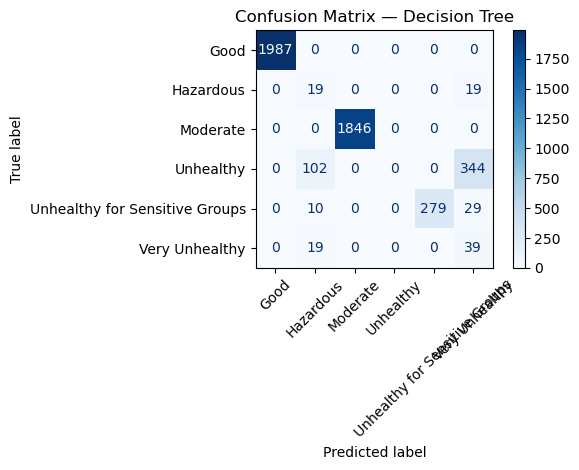

Classification Report — Decision Tree
                                precision    recall  f1-score   support

                          Good       1.00      1.00      1.00      1987
                     Hazardous       0.13      0.50      0.20        38
                      Moderate       1.00      1.00      1.00      1846
                     Unhealthy       0.00      0.00      0.00       446
Unhealthy for Sensitive Groups       1.00      0.88      0.93       318
                Very Unhealthy       0.09      0.67      0.16        58

                      accuracy                           0.89      4693
                     macro avg       0.54      0.67      0.55      4693
                  weighted avg       0.89      0.89      0.88      4693

Accuracy (Decision Tree): 0.8886


In [14]:
# hiperparameters
clf = DecisionTreeClassifier(
    max_depth=4, 
    min_samples_leaf=5, 
    criterion='entropy', 
    class_weight='balanced',
)

clf.fit(X_train, y_train)
y_pred_dt = clf.predict(X_test)

# Confusion matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)
ConfusionMatrixDisplay(cm_dt, display_labels=le.classes_).plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix — Decision Tree")
plt.tight_layout()
plt.savefig("images/air_polution/algorithms/decision_tree_air")
plt.show()

# Classification report
print("Classification Report — Decision Tree")
report_dt = classification_report(y_test, y_pred_dt, target_names=le.classes_, zero_division=0)
print(report_dt)

accuracy_dt_air = accuracy_score(y_test, y_pred_dt)
print(f"Accuracy (Decision Tree): {accuracy_dt_air:.4f}")

#### Random Forest

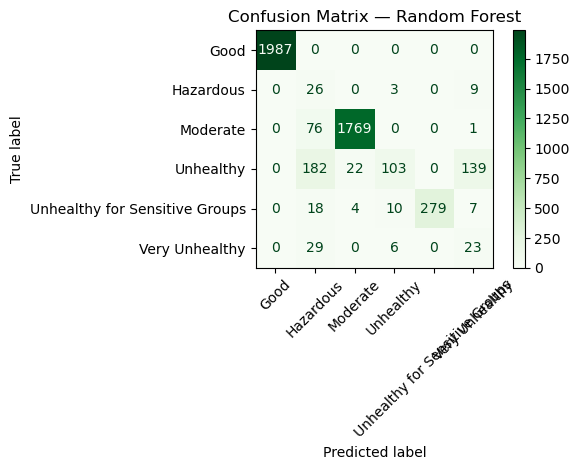

Classification Report — Random Forest
                                precision    recall  f1-score   support

                          Good       1.00      1.00      1.00      1987
                     Hazardous       0.08      0.68      0.14        38
                      Moderate       0.99      0.96      0.97      1846
                     Unhealthy       0.84      0.23      0.36       446
Unhealthy for Sensitive Groups       1.00      0.88      0.93       318
                Very Unhealthy       0.13      0.40      0.19        58

                      accuracy                           0.89      4693
                     macro avg       0.67      0.69      0.60      4693
                  weighted avg       0.96      0.89      0.91      4693

Accuracy (Random Forest): 0.8922


In [15]:
# hiperparameters
rf = RandomForestClassifier(
    max_depth=4,
    min_samples_leaf=5,
    criterion='entropy', 
    class_weight='balanced',
    n_estimators=100,
    max_samples=0.8,
    max_features='sqrt',
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
ConfusionMatrixDisplay(cm_rf, display_labels=le.classes_).plot(cmap='Greens', xticks_rotation=45)
plt.title("Confusion Matrix — Random Forest")
plt.tight_layout()
plt.savefig("images/air_polution/algorithms/random_forest_air")
plt.show()

print("Classification Report — Random Forest")
report_rf = classification_report(y_test, y_pred_rf, target_names=le.classes_, zero_division=0)
print(report_rf)

accuracy_rf_air = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy (Random Forest): {accuracy_rf_air:.4f}")

#### Logistics Regresion

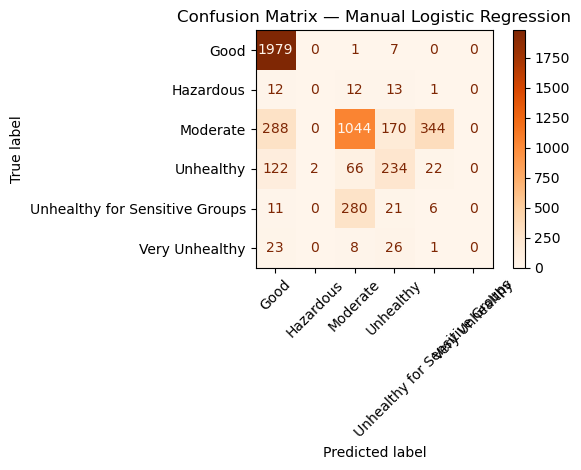

Classification Report — Manual Logistic Regression
                                precision    recall  f1-score   support

                          Good       0.81      1.00      0.90      1987
                     Hazardous       0.00      0.00      0.00        38
                      Moderate       0.74      0.57      0.64      1846
                     Unhealthy       0.50      0.52      0.51       446
Unhealthy for Sensitive Groups       0.02      0.02      0.02       318
                Very Unhealthy       0.00      0.00      0.00        58

                      accuracy                           0.70      4693
                     macro avg       0.34      0.35      0.34      4693
                  weighted avg       0.68      0.70      0.68      4693

Accuracy (Manual Logistic Regression): 0.6953


In [16]:
# Train Manual Logistic Regression
logreg = ManualLogisticRegression(lr=0.1, epochs=3000, l2_lambda=0.01)
logreg.fit(X_train.values, y_train)

# Predictions
y_pred_logreg = logreg.predict(X_test.values)

# Confusion Matrix
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
ConfusionMatrixDisplay(cm_logreg, display_labels=le.classes_).plot(cmap='Oranges', xticks_rotation=45)
plt.title("Confusion Matrix — Manual Logistic Regression")
plt.tight_layout()
plt.savefig("images/air_polution/algorithms/logistic_regression_air")
plt.show()

# Classification Report
print("Classification Report — Manual Logistic Regression")
report_logreg = classification_report(y_test, y_pred_logreg, target_names=le.classes_, zero_division=0)
print(report_logreg)

# Accuracy
accuracy_logreg_air = accuracy_score(y_test, y_pred_logreg)
print(f"Accuracy (Manual Logistic Regression): {accuracy_logreg_air:.4f}")


#### MLP

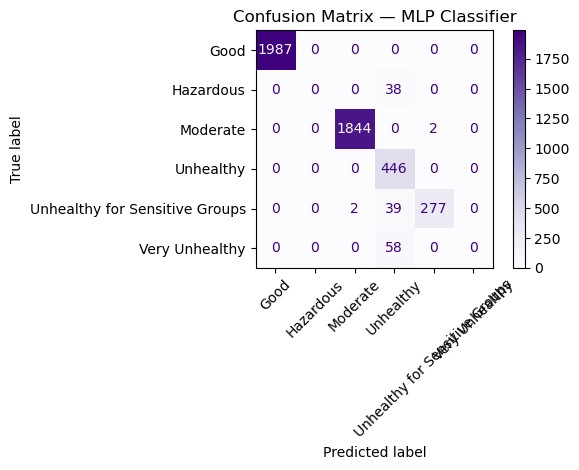

Classification Report — MLP Classifier
                                precision    recall  f1-score   support

                          Good       1.00      1.00      1.00      1987
                     Hazardous       0.00      0.00      0.00        38
                      Moderate       1.00      1.00      1.00      1846
                     Unhealthy       0.77      1.00      0.87       446
Unhealthy for Sensitive Groups       0.99      0.87      0.93       318
                Very Unhealthy       0.00      0.00      0.00        58

                      accuracy                           0.97      4693
                     macro avg       0.63      0.64      0.63      4693
                  weighted avg       0.96      0.97      0.96      4693

Accuracy (MLP): 0.9704


In [17]:
# hiperparameters
mlp = MLPClassifier(
    hidden_layer_sizes=(256, 128),
    activation='relu',
    solver='adam',
    learning_rate_init=0.001,
    max_iter=3000,
    early_stopping=True,
    alpha=0.0001,
)

mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

# Confusion Matrix
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
ConfusionMatrixDisplay(cm_mlp, display_labels=le.classes_).plot(cmap='Purples', xticks_rotation=45)
plt.title("Confusion Matrix — MLP Classifier")
plt.tight_layout()
plt.savefig("images/air_polution/algorithms/mlp_air")
plt.show()

# Classification Report
print("Classification Report — MLP Classifier")
report_mlp = classification_report(y_test, y_pred_mlp, target_names=le.classes_, zero_division=0)
print(report_mlp)

accuracy_mlp_air = accuracy_score(y_test, y_pred_mlp)
print(f"Accuracy (MLP): {accuracy_mlp_air:.4f}")

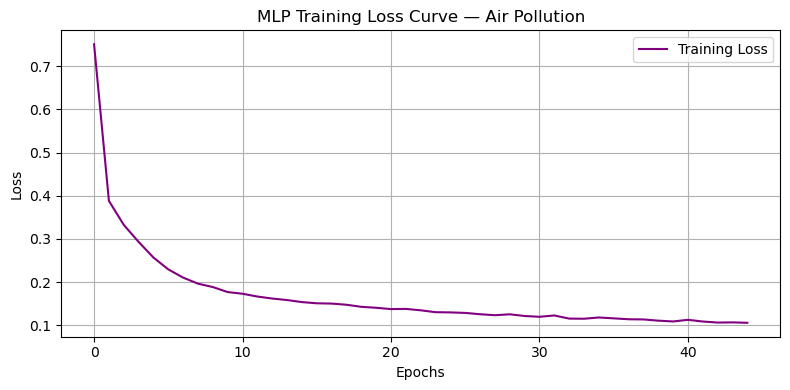

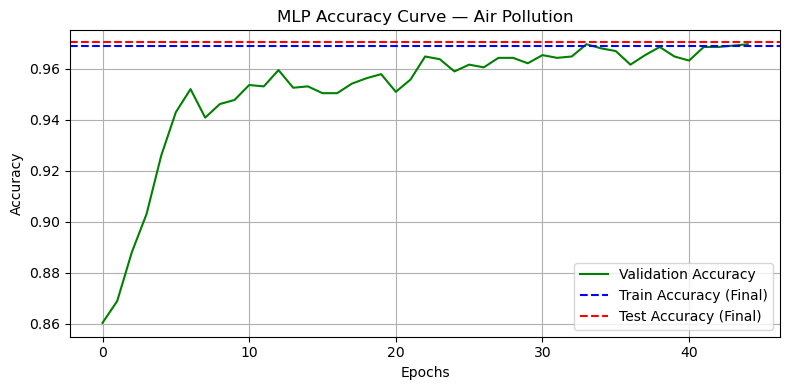

In [18]:
# Loss curve
plt.figure(figsize=(8, 4))
plt.plot(mlp.loss_curve_, label='Training Loss', color='purple')
plt.title('MLP Training Loss Curve — Air Pollution')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("images/air_polution/algorithms/mlp_loss_curve.png")
plt.show()

# Accuracy curve (train și validation)
val_scores = mlp.validation_scores_

train_acc = accuracy_score(y_train, mlp.predict(X_train))
test_acc = accuracy_score(y_test, mlp.predict(X_test))

plt.figure(figsize=(8, 4))
plt.plot(val_scores, label='Validation Accuracy', color='green')
plt.axhline(y=train_acc, color='blue', linestyle='--', label='Train Accuracy (Final)')
plt.axhline(y=test_acc, color='red', linestyle='--', label='Test Accuracy (Final)')
plt.title('MLP Accuracy Curve — Air Pollution')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("images/air_polution/algorithms/mlp_accuracy_curve.png")
plt.show()


## News popularity data set 

### I. EDA (Exploratory Data Analysis)

#### 0. Load csv file

In [19]:
# Load data
newsDataFull = pd.read_csv('data/news_popularity_full.csv')

if 'url' in newsDataFull.columns:
    newsDataFull = newsDataFull.drop(columns=['url'])

newsDataFull.columns = newsDataFull.columns.str.strip()

newsDataFull.head(n=5)

,days_since_published,title_word_count,content_word_count,unique_word_ratio,non_stop_word_ratio,unique_non_stop_ratio,external_links,internal_links,image_count,video_count,...,min_negative_sentiment,max_negative_sentiment,title_subjectivity,title_sentiment,title_subjectivity_magnitude,title_sentiment_magnitude,engagement_ratio,content_density,publication_period,popularity_category
0,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,...,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,296.500000,626.086470,Weekday,Slightly Popular
1,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,...,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,355.500000,772.976656,Weekday,Slightly Popular
2,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,...,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,750.000000,678.303680,Weekday,Moderately Popular
3,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,...,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,600.000000,1816.511012,Weekday,Slightly Popular
4,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,...,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,24.047619,4206.723588,Weekday,Slightly Popular


#### 1. Analyse the type of attributes and their range of values

##### Attribute types

In [20]:
numeric_cols_news = newsDataFull.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols_news = newsDataFull.select_dtypes(include=['object']).columns.tolist()

continuous_features_news = []
discrete_features_news = []
ordinal_features_news = ['popularity_category']

# Continuous features
for col in numeric_cols_news:
    unique_vals = newsDataFull[col].nunique()
    value_range = newsDataFull[col].max() - newsDataFull[col].min()

    if unique_vals > 20 and value_range > 50:
        continuous_features_news.append(col)
    else:
        discrete_features_news.append(col)

# Categorical features
categorical_features_news = [col for col in categorical_cols_news if col not in ordinal_features_news]

# Results
print("Continuous features:", continuous_features_news)
print("Discrete features:", discrete_features_news)
print("Ordinal features:", ordinal_features_news)
print("Categorical features:", categorical_features_news)

Continuous features: ['days_since_published', 'content_word_count', 'unique_word_ratio', 'non_stop_word_ratio', 'unique_non_stop_ratio', 'external_links', 'internal_links', 'image_count', 'video_count', 'keyword_worst_min_shares', 'keyword_worst_max_shares', 'keyword_worst_avg_shares', 'keyword_best_min_shares', 'keyword_best_max_shares', 'keyword_best_avg_shares', 'keyword_avg_min_shares', 'keyword_avg_max_shares', 'keyword_avg_avg_shares', 'ref_min_shares', 'ref_max_shares', 'ref_avg_shares', 'engagement_ratio', 'content_density']
Discrete features: ['title_word_count', 'avg_word_length', 'keyword_count', 'topic_0_relevance', 'topic_1_relevance', 'topic_2_relevance', 'topic_3_relevance', 'topic_4_relevance', 'content_subjectivity', 'content_sentiment', 'positive_word_rate', 'negative_word_rate', 'non_neutral_positive_rate', 'non_neutral_negative_rate', 'avg_positive_sentiment', 'min_positive_sentiment', 'max_positive_sentiment', 'avg_negative_sentiment', 'min_negative_sentiment', 'ma

##### Continuous attribute analysis and boxplot

,count,mean,std,min,25%,50%,75%,max
days_since_published,39644.0,354.530471,214.163767,8.000000,164.000000,339.000000,542.000000,731.000000
content_word_count,39644.0,546.514731,471.107508,0.000000,246.000000,409.000000,716.000000,8474.000000
unique_word_ratio,39644.0,0.548216,3.520708,0.000000,0.470870,0.539226,0.608696,701.000000
non_stop_word_ratio,39644.0,0.996469,5.231231,0.000000,1.000000,1.000000,1.000000,1042.000000
unique_non_stop_ratio,39644.0,0.689175,3.264816,0.000000,0.625739,0.690476,0.754630,650.000000
external_links,39644.0,192.250110,905.415876,0.000000,4.000000,8.000000,15.000000,6078.616775
internal_links,39644.0,3.293638,3.855141,0.000000,1.000000,3.000000,4.000000,116.000000
image_count,39644.0,4.544143,8.309434,0.000000,1.000000,1.000000,4.000000,128.000000
video_count,39644.0,1.249874,4.107855,0.000000,0.000000,0.000000,1.000000,91.000000
keyword_worst_min_shares,39644.0,26.106801,69.633215,-1.000000,-1.000000,-1.000000,4.000000,377.000000


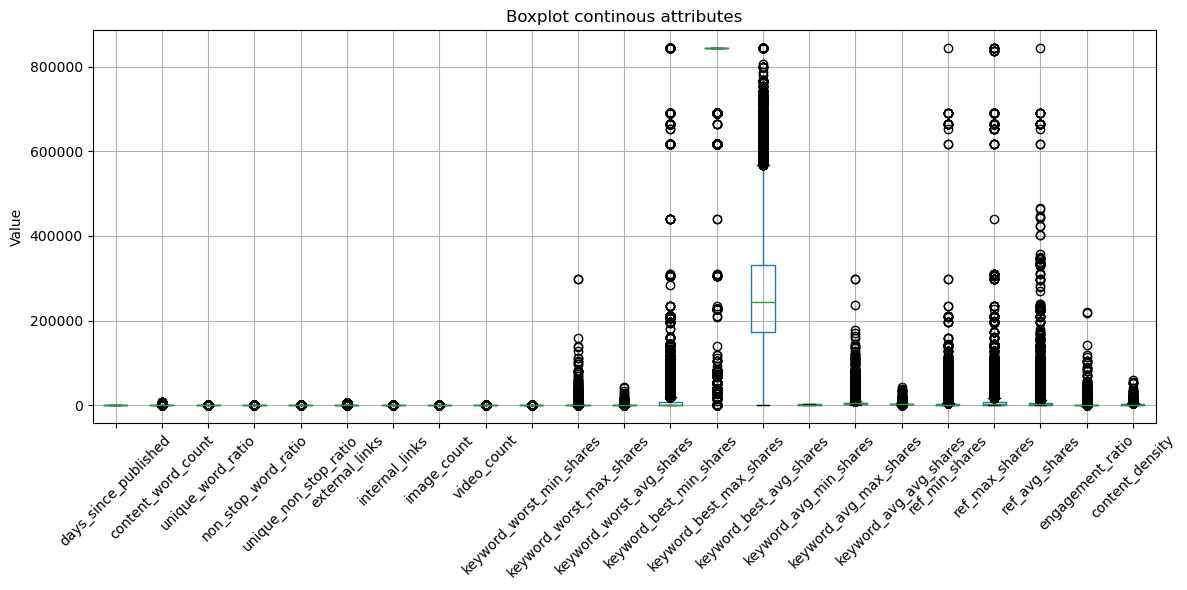

In [21]:
# Description
display(newsDataFull[continuous_features_news].describe().T)

# Boxplot config
plt.figure(figsize=(12, 6))
newsDataFull[continuous_features_news].boxplot(rot=45)

plt.title("Boxplot continous attributes")
plt.ylabel("Value")

plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig("images/news_popularity/boxplot/boxplot_cont_feat_news")
plt.show()

##### Ordinal attribute analysis and histogram

popularity_category — Number of non-null examples: 39644
popularity_category — Number of unique values: 5



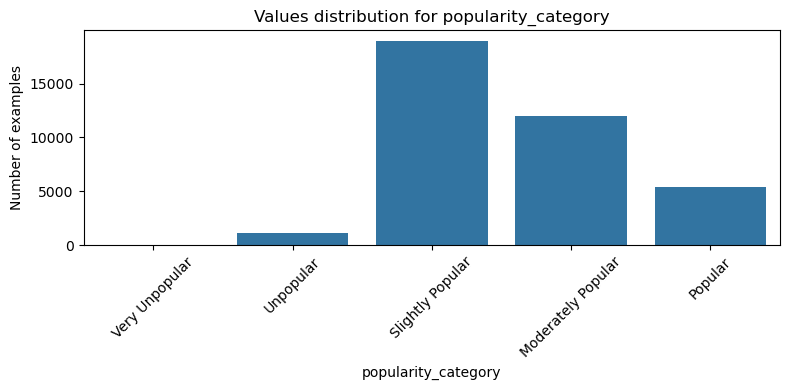

channel_lifestyle — Number of non-null examples: 35680
channel_lifestyle — Number of unique values: 2



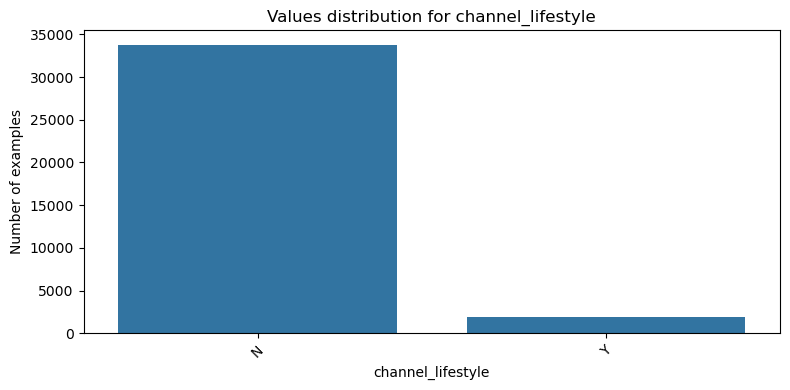

channel_entertainment — Number of non-null examples: 39644
channel_entertainment — Number of unique values: 2



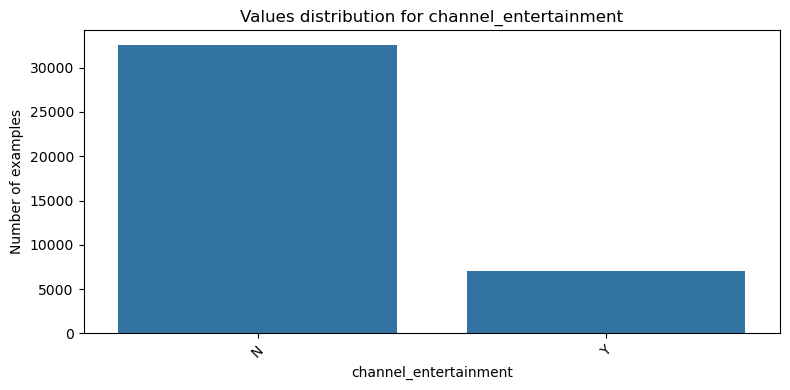

channel_business — Number of non-null examples: 39644
channel_business — Number of unique values: 2



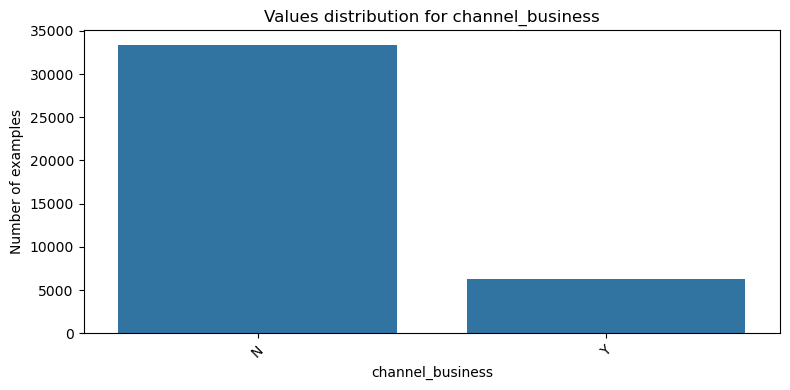

channel_social_media — Number of non-null examples: 39644
channel_social_media — Number of unique values: 2



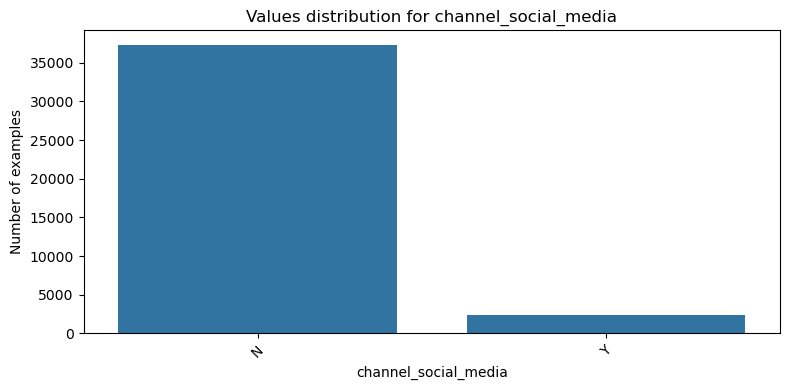

channel_tech — Number of non-null examples: 39644
channel_tech — Number of unique values: 2



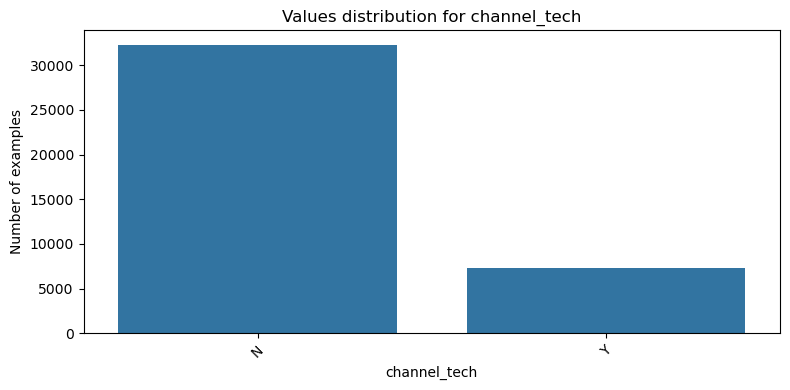

channel_world — Number of non-null examples: 39644
channel_world — Number of unique values: 2



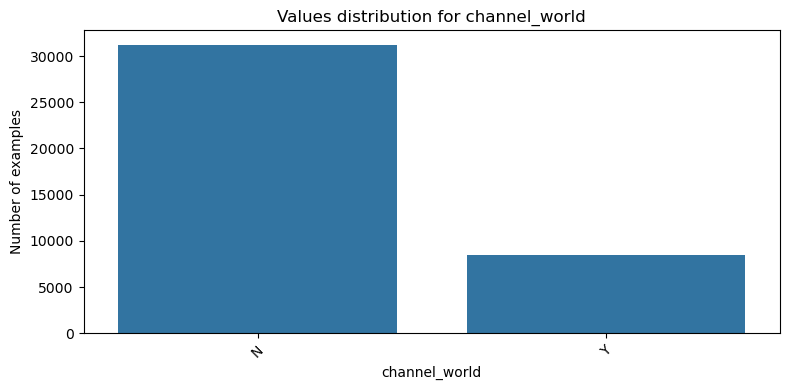

day_monday — Number of non-null examples: 39644
day_monday — Number of unique values: 2



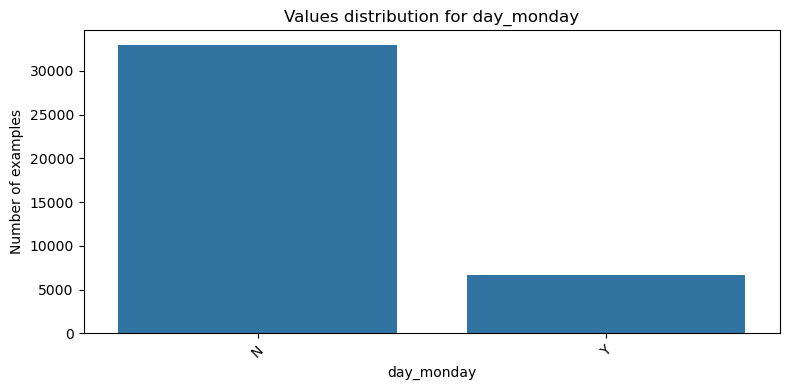

day_tuesday — Number of non-null examples: 39644
day_tuesday — Number of unique values: 2



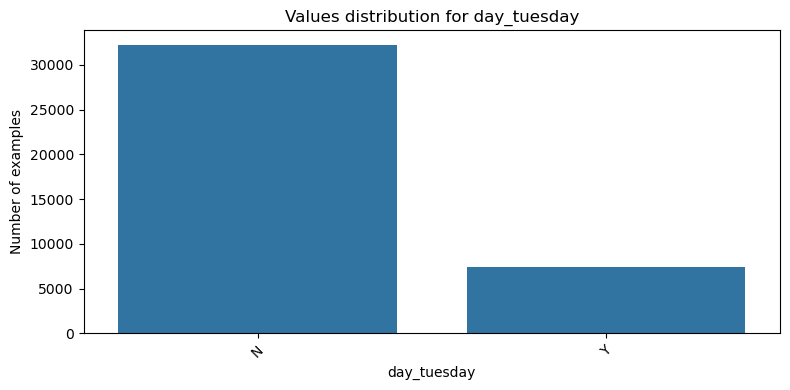

day_wednesday — Number of non-null examples: 39644
day_wednesday — Number of unique values: 2



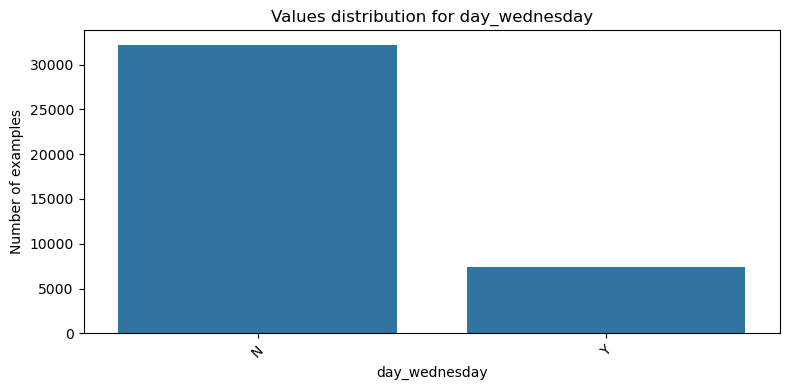

day_thursday — Number of non-null examples: 39644
day_thursday — Number of unique values: 2



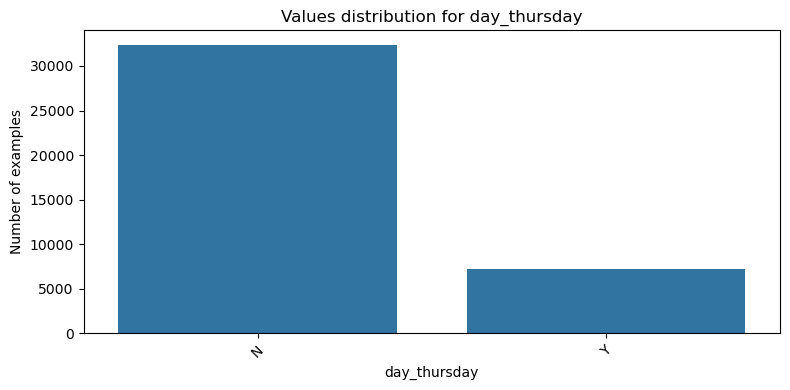

day_friday — Number of non-null examples: 39644
day_friday — Number of unique values: 2



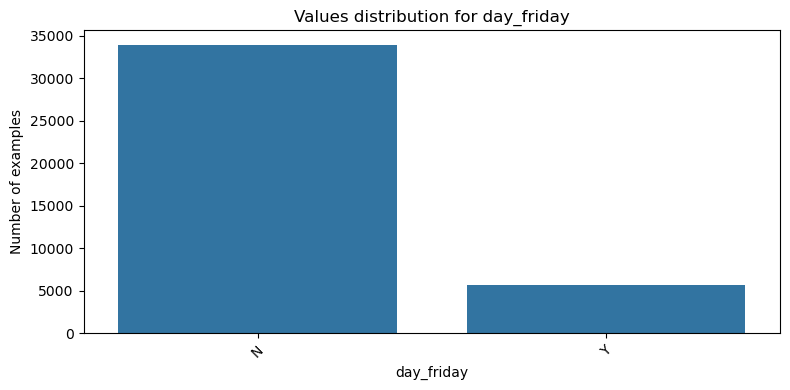

day_saturday — Number of non-null examples: 39644
day_saturday — Number of unique values: 2



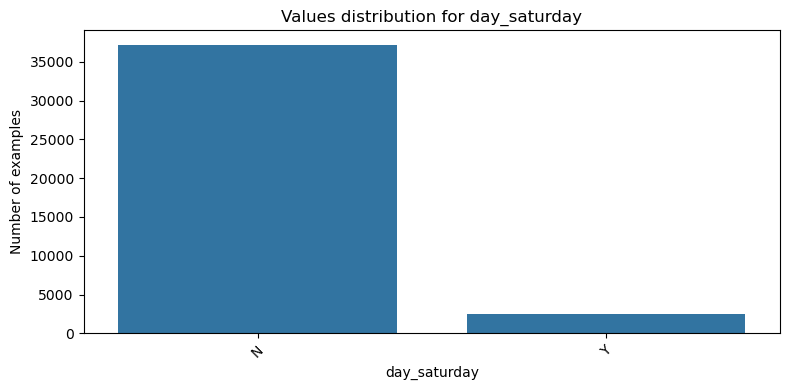

day_sunday — Number of non-null examples: 39644
day_sunday — Number of unique values: 2



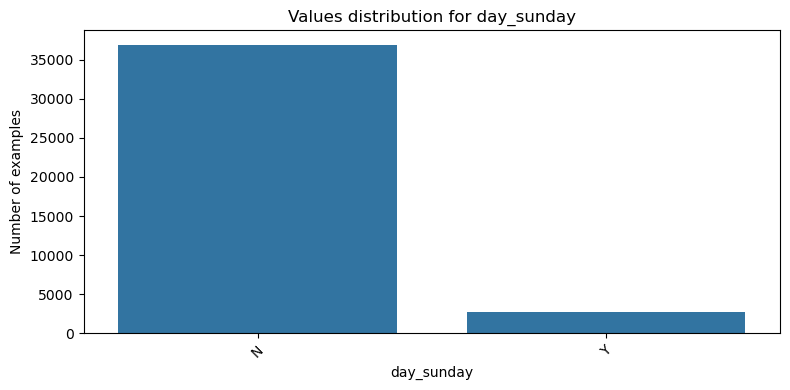

is_weekend — Number of non-null examples: 39644
is_weekend — Number of unique values: 2



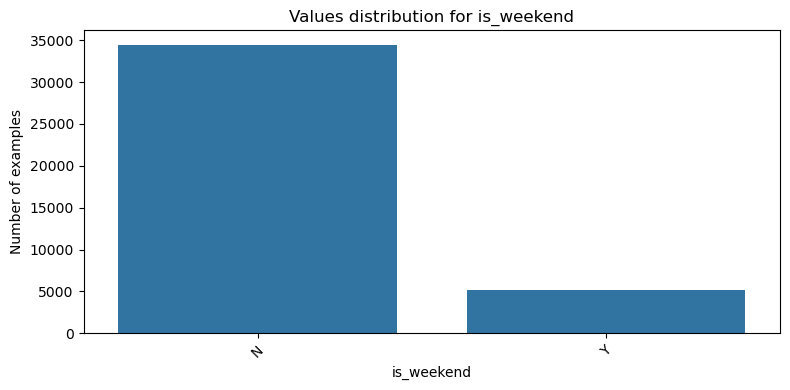

publication_period — Number of non-null examples: 39644
publication_period — Number of unique values: 2



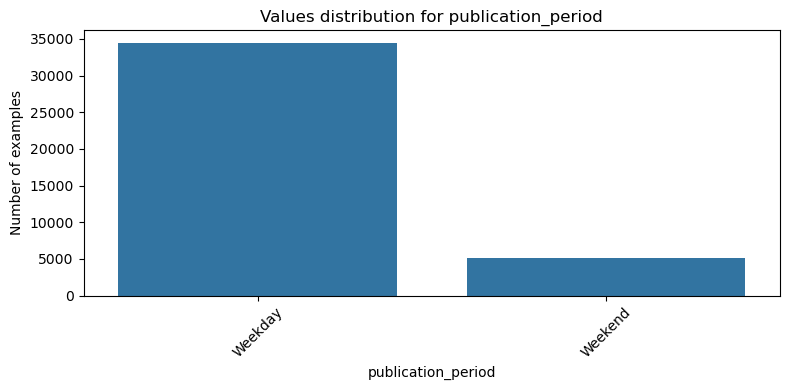

In [22]:
custom_orders_news = {
    'popularity_category': [
        'Very Unpopular', 'Unpopular', 'Slightly Popular',
        'Moderately Popular', 'Popular'
    ]
}

all_cat_news = ordinal_features_news + categorical_features_news

summary_data_news = []

for col in all_cat_news:
    non_null_count = newsDataFull[col].notna().sum()
    unique_count = newsDataFull[col].nunique()

    print(f"{col} — Number of non-null examples: {non_null_count}")
    print(f"{col} — Number of unique values: {unique_count}\n")

    summary_data_news.append((col, non_null_count, unique_count))

    counts = newsDataFull[col].value_counts().sort_index()
    order = custom_orders_news.get(col, counts.index)

    plt.figure(figsize=(8, 4))
    sns.countplot(data=newsDataFull, x=col, order=order)
    plt.title(f"Values distribution for {col}")
    plt.xlabel(col)
    plt.ylabel("Number of examples")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"images/news_popularity/histogram/histogram_categ_feat_news_{col}", dpi=300)
    plt.show()

#### 2. Class balance analysis

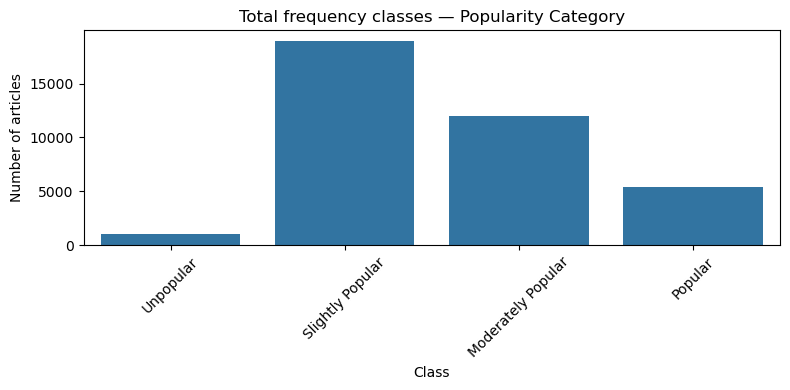

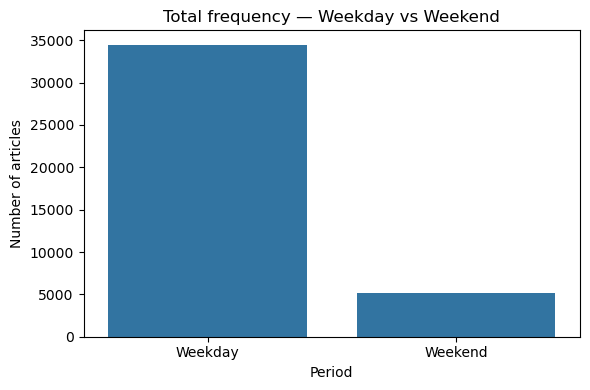

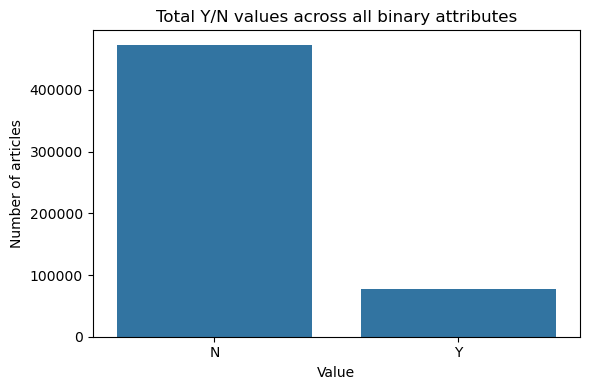

In [23]:
# Popularity category classes
popularity_labels = [
    'Very Unpopular', 'Unpopular', 'Slightly Popular',
    'Moderately Popular', 'Popular'
]

popularity_counter = Counter(newsDataFull['popularity_category'].dropna())
popularity_df = pd.DataFrame.from_dict(popularity_counter, orient='index', columns=['Frequency'])
popularity_df = popularity_df.reindex(popularity_labels).dropna()

plt.figure(figsize=(8, 4))
sns.barplot(x=popularity_df.index, y=popularity_df['Frequency'])
plt.title("Total frequency classes — Popularity Category")
plt.xlabel("Class")
plt.ylabel("Number of articles")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("images/news_popularity/boxplot/boxplot_classes_unpopular-popular.png")
plt.show()

# 2. Publication Period (Weekday/Weekend)
newsDataFull.columns = newsDataFull.columns.str.strip()
if 'publication_period' in newsDataFull.columns:
    pub_labels = ['Weekday', 'Weekend']
    pub_counter = Counter(newsDataFull['publication_period'].dropna())
    pub_df = pd.DataFrame.from_dict(pub_counter, orient='index', columns=['Frequency'])
    pub_df = pub_df.reindex(pub_labels).dropna()

    plt.figure(figsize=(6, 4))
    sns.barplot(x=pub_df.index, y=pub_df['Frequency'])
    plt.title("Total frequency — Weekday vs Weekend")
    plt.xlabel("Period")
    plt.ylabel("Number of articles")
    plt.tight_layout()
    plt.savefig("images/news_popularity/boxplot/boxplot_classes_weekday-weekend.png")
    plt.show()

# 3. Aggregated Y/N distribution across all binary columns
binary_yn_cols = [
    col for col in newsDataFull.columns
    if newsDataFull[col].dropna().isin(['Y', 'N']).all()
]

yn_counter = Counter()
for col in binary_yn_cols:
    yn_counter.update(newsDataFull[col][newsDataFull[col].isin(['Y', 'N'])])

yn_df = pd.DataFrame.from_dict(yn_counter, orient='index', columns=['Frequency'])
yn_df = yn_df.reindex(['N', 'Y']).dropna()

plt.figure(figsize=(6, 4))
sns.barplot(x=yn_df.index, y=yn_df['Frequency'])
plt.title("Total Y/N values across all binary attributes")
plt.xlabel("Value")
plt.ylabel("Number of articles")
plt.tight_layout()
plt.savefig("images/news_popularity/boxplot/boxplot_classes_yes-no_combined.png")
plt.show()

#### 3. Corelation between atributes analysis

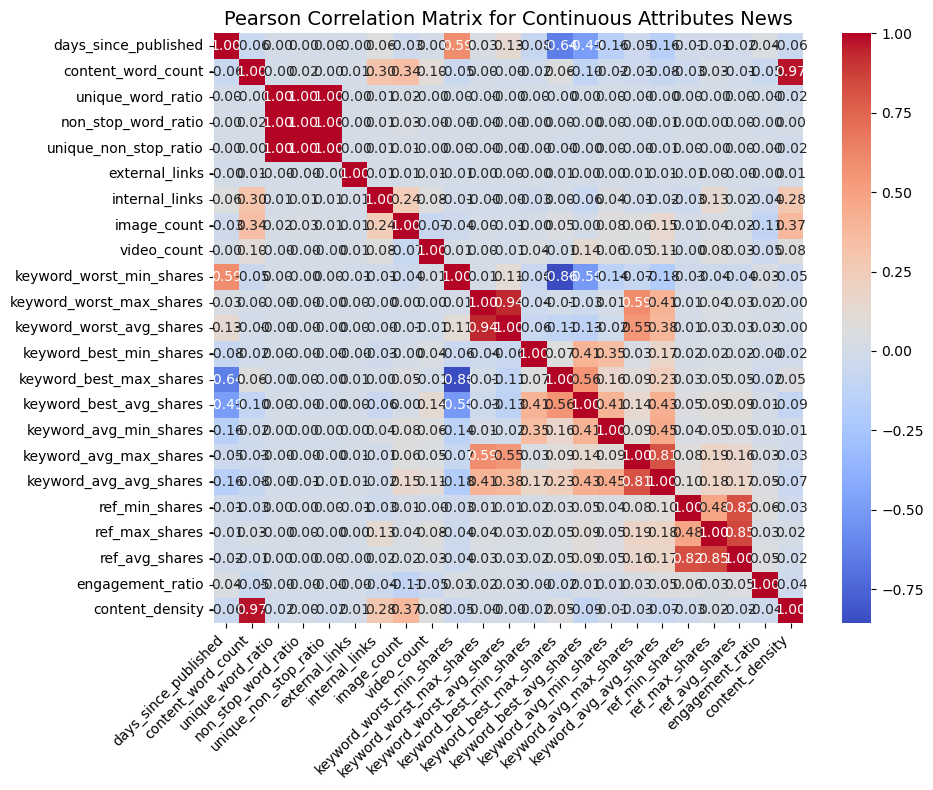

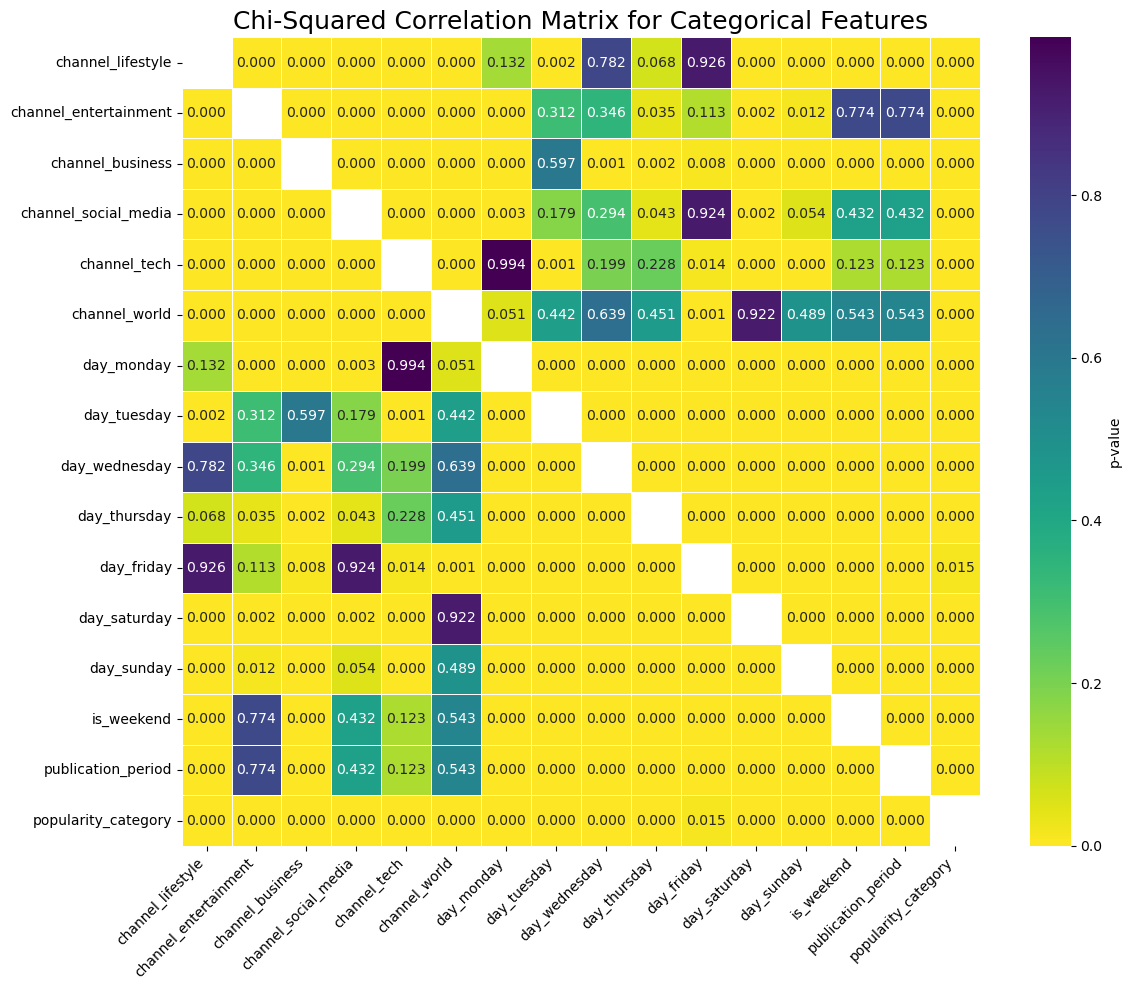

In [24]:
correlation_matrix_continous = newsDataFull[continuous_features_news].corr(method='pearson')

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_continous, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)
plt.title("Pearson Correlation Matrix for Continuous Attributes News", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("images/news_popularity/correlation/correlation_cont_matrix_news")
plt.show()


categorical_combinations = list(combinations(categorical_features_news + ordinal_features_news, 2))

chi2_results = [] # (feature1, feature2, p_value)

for var1, var2 in categorical_combinations:
    contingency_table = pd.crosstab(newsDataFull[var1], newsDataFull[var2])
    if contingency_table.shape[0] > 1 and contingency_table.shape[1] > 1:
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        chi2_results.append((var1, var2, p))

pval_matrix = pd.DataFrame(np.nan, index=categorical_features_news + ordinal_features_news, columns=categorical_features_news + ordinal_features_news)

for var1, var2, p in chi2_results:
    pval_matrix.loc[var1, var2] = p
    pval_matrix.loc[var2, var1] = p

plt.figure(figsize=(12, 10))
sns.heatmap(
    pval_matrix,
    cmap='viridis_r',
    annot=True,
    fmt=".3f",
    cbar_kws={'label': 'p-value'},
    linewidths=.5
)
plt.title("Chi-Squared Correlation Matrix for Categorical Features", fontsize=18)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("images/news_popularity/correlation/correlation_ordinal_matrix")
plt.show()

### II. Data pre-processing

#### 0. Load csv file

In [25]:
# Load data
newsDataTrain = pd.read_csv('data/news_popularity_train.csv')
newsDataTest = pd.read_csv('data/news_popularity_test.csv')

if 'url' in newsDataTrain.columns:
    newsDataTrain = newsDataTrain.drop(columns=['url'])

if 'url' in newsDataTest.columns:
    newsDataTest = newsDataTest.drop(columns=['url'])

#### 1. Identification of attributes with missing values

In [26]:
# Number of missing values
missing_train = newsDataTrain.isnull().sum()
missing_train = missing_train[missing_train > 0].sort_values(ascending=False)

print("Atributes with missing values:")
display(missing_train)

# Columns
numeric_train_cols_news = newsDataTrain.select_dtypes(include=['float64', 'int64']).columns
categorical_train_cols = newsDataTrain.select_dtypes(include=['object']).columns

# Split atrributes with missing values
missing_numeric = [col for col in missing_train.index if col in numeric_train_cols_news]
missing_categorical = [col for col in missing_train.index if col in categorical_train_cols]

# Simple imputer for numerical using mean
if missing_numeric:
    imputer_numeric = SimpleImputer(strategy='mean')
    newsDataTrain[missing_numeric] = imputer_numeric.fit_transform(newsDataTrain[missing_numeric])
    newsDataTest[missing_numeric] = imputer_numeric.transform(newsDataTest[missing_numeric])

# Simple imputer for ordinal using most_frequent
if missing_categorical:
    for col in missing_categorical:
        newsDataTrain[col] = newsDataTrain[col].astype('object')
        newsDataTest[col] = newsDataTest[col].astype('object')
    imputer_categorical = SimpleImputer(strategy='most_frequent')
    newsDataTrain[missing_categorical] = imputer_categorical.fit_transform(newsDataTrain[missing_categorical])
    newsDataTest[missing_categorical] = imputer_categorical.transform(newsDataTest[missing_categorical])

print("After imputation, missing values in train:")
display(newsDataTrain[missing_train.index].isnull().sum())


Atributes with missing values:


 channel_lifestyle    3175
 content_density      3145
dtype: int64

After imputation, missing values in train:


 channel_lifestyle    0
 content_density      0
dtype: int64

#### 2. Elimination of attributes with extreme values

In [27]:
# Table to set outliers per column
iqr_bounds = {}

for col in numeric_train_cols_news:
    # Computes Q1, Q3, IQR on train
    Q1 = newsDataTrain[col].quantile(0.25)
    Q3 = newsDataTrain[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    iqr_bounds[col] = (lower_bound, upper_bound)

    # Marks outliers on train
    train_outliers_mask = (newsDataTrain[col] < lower_bound) | (newsDataTrain[col] > upper_bound)
    num_train_outliers = train_outliers_mask.sum()
    newsDataTrain.loc[train_outliers_mask, col] = np.nan

    print(f"[Train] {col}: {num_train_outliers} outliers replaced with NaN")

print("\nReplacing outliers with NaN in newsDataTrain using train IQR...")

for col in numeric_train_cols_news:
    lower_bound, upper_bound = iqr_bounds[col]

    # Marks outliers in test using train limits
    test_outliers_mask = (newsDataTrain[col] < lower_bound) | (newsDataTrain[col] > upper_bound)
    num_test_outliers = test_outliers_mask.sum()
    newsDataTrain.loc[test_outliers_mask, col] = np.nan

    print(f"[Test] {col}: {num_test_outliers} outliers replaced with NaN")

# Imputes missing values
imputer_outliers = SimpleImputer(strategy='mean')
newsDataTrain[numeric_train_cols_news] = imputer_outliers.fit_transform(newsDataTrain[numeric_train_cols_news])
newsDataTest[numeric_train_cols_news] = imputer_outliers.transform(newsDataTest[numeric_train_cols_news])

print("\nOutliers replaced with NaN and imputed with column mean.")


[Train]  days_since_published: 0 outliers replaced with NaN
[Train]  title_word_count: 123 outliers replaced with NaN
[Train]  content_word_count: 1539 outliers replaced with NaN
[Train]  unique_word_ratio: 1290 outliers replaced with NaN
[Train]  non_stop_word_ratio: 2234 outliers replaced with NaN
[Train]  unique_non_stop_ratio: 1393 outliers replaced with NaN
[Train]  external_links: 2665 outliers replaced with NaN
[Train]  internal_links: 1674 outliers replaced with NaN
[Train]  image_count: 6159 outliers replaced with NaN
[Train]  video_count: 2330 outliers replaced with NaN
[Train]  avg_word_length: 1363 outliers replaced with NaN
[Train]  keyword_count: 47 outliers replaced with NaN
[Train]  keyword_worst_min_shares: 3743 outliers replaced with NaN
[Train]  keyword_worst_max_shares: 2939 outliers replaced with NaN
[Train]  keyword_worst_avg_shares: 1694 outliers replaced with NaN
[Train]  keyword_best_min_shares: 4025 outliers replaced with NaN
[Train]  keyword_best_max_shares: 

#### 3. Elimination of redundant attributes

In [28]:
# Attributes identified as redundant from the correlation analysis
redundant_continuous_news = [ # correlation > 0.95
    'content_density',
    'non_stop_word_ratio',
    'unique_non_stop_ratio',
    'keyword_best_avg_shares',
    'keyword_avg_avg_shares',
    'ref_avg_shares',
]

redundant_categorical_news = [ # p < 0.05
    'publication_period',
    'is_weekend',
    'channel_business', 'channel_entertainment',
    'channel_lifestyle', 'channel_social_media',
    'channel_tech', 'channel_world',
    'day_monday', 'day_tuesday', 'day_wednesday',
    'day_thursday', 'day_friday', 'day_saturday', 'day_sunday',
]

# Combine them
redundant_features_news = redundant_continuous_news + redundant_categorical_news
print(f"Removed redundant features: {redundant_features_news}")

newsDataTrain = newsDataTrain.drop(columns=redundant_features_news, errors='ignore')
newsDataTest = newsDataTest.drop(columns=redundant_features_news, errors='ignore')

Removed redundant features: ['content_density', 'non_stop_word_ratio', 'unique_non_stop_ratio', 'keyword_best_avg_shares', 'keyword_avg_avg_shares', 'ref_avg_shares', 'publication_period', 'is_weekend', 'channel_business', 'channel_entertainment', 'channel_lifestyle', 'channel_social_media', 'channel_tech', 'channel_world', 'day_monday', 'day_tuesday', 'day_wednesday', 'day_thursday', 'day_friday', 'day_saturday', 'day_sunday']


#### 4. Standardization of numerical attribute values

In [29]:
# Numerical atributes after removing redundant and extreme attributes
numeric_cols_removed = newsDataTrain.select_dtypes(include=['float64', 'int64']).columns.tolist()

scaler = StandardScaler()

newsDataTrain[numeric_cols_removed] = scaler.fit_transform(newsDataTrain[numeric_cols_removed])
newsDataTest[numeric_cols_removed] = scaler.transform(newsDataTest[numeric_cols_removed])

print("Numerical features have been standardized using StandardScaler.")

Numerical features have been standardized using StandardScaler.


### III. ML algorithms

##### Enconding Categorical Attributes

In [30]:
# Define target
target_column = 'popularity_category'

# Encode target
le = LabelEncoder()
y_train_news = le.fit_transform(newsDataTrain[target_column])
y_test_news = le.transform(newsDataTest[target_column])

# Select categorical columns with low cardinality
low_cardinality_cols = [
    col for col in newsDataTrain.select_dtypes(include='object').columns
    if col != target_column
]

# ColumnTransformer with OneHotEncoder only on selected features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), low_cardinality_cols)
    ],
    remainder='passthrough'  # keeps numeric features
)

# Apply transform
X_train_news = preprocessor.fit_transform(newsDataTrain.drop(columns=[target_column]))
X_test_news = preprocessor.transform(newsDataTest.drop(columns=[target_column]))

print(f"Shape after encoding: X_train={X_train_news.shape}, X_test={X_test_news.shape}")

Shape after encoding: X_train=(31715, 77), X_test=(7929, 77)


#### Decision Trees

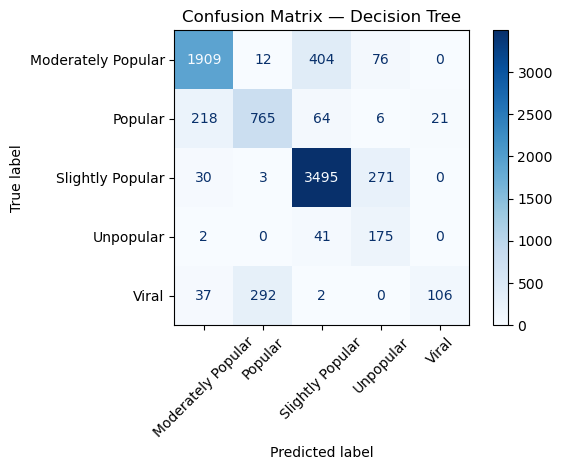

Classification Report — Decision Tree
                    precision    recall  f1-score   support

Moderately Popular       0.87      0.80      0.83      2401
           Popular       0.71      0.71      0.71      1074
  Slightly Popular       0.87      0.92      0.90      3799
         Unpopular       0.33      0.80      0.47       218
             Viral       0.83      0.24      0.38       437

          accuracy                           0.81      7929
         macro avg       0.72      0.69      0.66      7929
      weighted avg       0.83      0.81      0.81      7929

Accuracy (Decision Tree): 0.8135


In [31]:
# hiperparameters
clf = DecisionTreeClassifier(
    max_depth=20, 
    min_samples_leaf=5, 
    criterion='entropy', 
    class_weight='balanced',
)

clf.fit(X_train_news, y_train_news)
y_pred_dt = clf.predict(X_test_news)

# Confusion matrix
cm_dt = confusion_matrix(y_test_news, y_pred_dt)
ConfusionMatrixDisplay(cm_dt, display_labels=le.classes_).plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix — Decision Tree")
plt.tight_layout()
plt.savefig("images/news_popularity/algorithms/decision_tree_news")
plt.show()

# Classification report
print("Classification Report — Decision Tree")
report_dt = classification_report(y_test_news, y_pred_dt, target_names=le.classes_, zero_division=0)
print(report_dt)

accuracy_dt_news = accuracy_score(y_test_news, y_pred_dt)
print(f"Accuracy (Decision Tree): {accuracy_dt_news:.4f}")

#### Random Forest

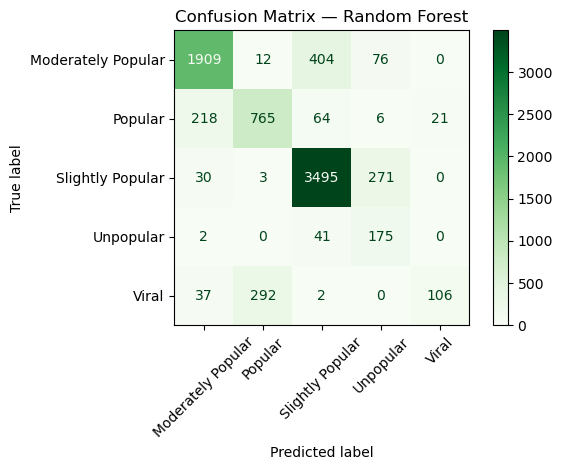

Classification Report — Random Forest
                    precision    recall  f1-score   support

Moderately Popular       0.87      0.80      0.83      2401
           Popular       0.71      0.71      0.71      1074
  Slightly Popular       0.87      0.92      0.90      3799
         Unpopular       0.33      0.80      0.47       218
             Viral       0.83      0.24      0.38       437

          accuracy                           0.81      7929
         macro avg       0.72      0.69      0.66      7929
      weighted avg       0.83      0.81      0.81      7929

Accuracy (Random Forest): 0.8135


In [32]:
# hiperparameters
rf = RandomForestClassifier(
    max_depth=4,
    min_samples_leaf=5,
    criterion='entropy', 
    class_weight='balanced',
    n_estimators=100,
    max_samples=0.8,
    max_features='sqrt',
)
rf.fit(X_train_news, y_train_news)
y_pred_rf = clf.predict(X_test_news)

# Confusion matrix
cm_rf = confusion_matrix(y_test_news, y_pred_rf)
ConfusionMatrixDisplay(cm_rf, display_labels=le.classes_).plot(cmap='Greens', xticks_rotation=45)
plt.title("Confusion Matrix — Random Forest")
plt.tight_layout()
plt.savefig("images/news_popularity/algorithms/random_forest_news")
plt.show()

print("Classification Report — Random Forest")
report_rf = classification_report(y_test_news, y_pred_rf, target_names=le.classes_, zero_division=0)
print(report_rf)

accuracy_rf_news = accuracy_score(y_test_news, y_pred_rf)
print(f"Accuracy (Random Forest): {accuracy_rf_news:.4f}")

#### Logistics Regresion

/home/filipinezul/1acs/an3/sem2/IA/ml_applied/manual_logistic_regression.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


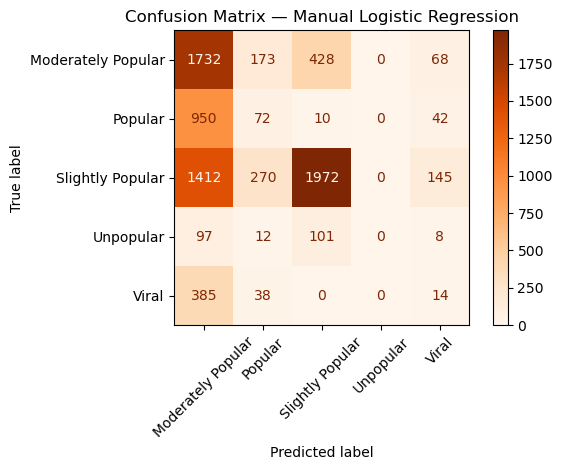

Classification Report — Manual Logistic Regression
                    precision    recall  f1-score   support

Moderately Popular       0.38      0.72      0.50      2401
           Popular       0.13      0.07      0.09      1074
  Slightly Popular       0.79      0.52      0.63      3799
         Unpopular       0.00      0.00      0.00       218
             Viral       0.05      0.03      0.04       437

          accuracy                           0.48      7929
         macro avg       0.27      0.27      0.25      7929
      weighted avg       0.51      0.48      0.46      7929

Accuracy (Manual Logistic Regression): 0.4780


In [33]:
# Antrenare
logreg = ManualLogisticRegression(lr=0.1, epochs=3000, l2_lambda=0.01)
logreg.fit(X_train_news, y_train_news)

# Predicție
y_pred_logreg = logreg.predict(X_test_news)

# Confusion Matrix
cm = confusion_matrix(y_test_news, y_pred_logreg)
ConfusionMatrixDisplay(cm, display_labels=le.classes_).plot(cmap='Oranges', xticks_rotation=45)
plt.title("Confusion Matrix — Manual Logistic Regression")
plt.tight_layout()
plt.savefig("images/news_popularity/algorithms/logistic_regression_news.png")
plt.show()

# Classification report
print("Classification Report — Manual Logistic Regression")
print(classification_report(y_test_news, y_pred_logreg, target_names=le.classes_, zero_division=0))

accuracy_logreg_news = accuracy_score(y_test_news, y_pred_logreg)
print(f"Accuracy (Manual Logistic Regression): {accuracy_logreg_news:.4f}")

#### MLP

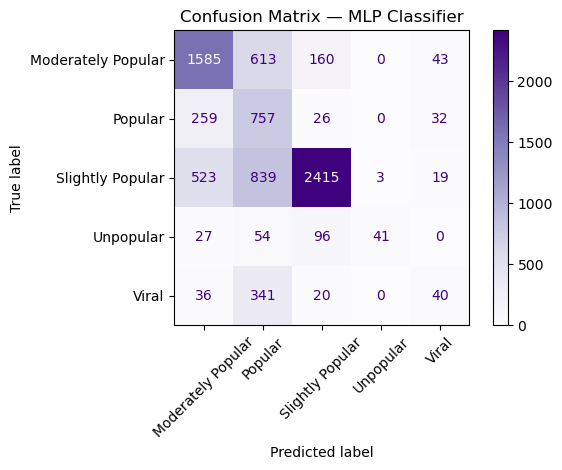

Classification Report — MLP Classifier
                    precision    recall  f1-score   support

Moderately Popular       0.65      0.66      0.66      2401
           Popular       0.29      0.70      0.41      1074
  Slightly Popular       0.89      0.64      0.74      3799
         Unpopular       0.93      0.19      0.31       218
             Viral       0.30      0.09      0.14       437

          accuracy                           0.61      7929
         macro avg       0.61      0.46      0.45      7929
      weighted avg       0.70      0.61      0.63      7929

Accuracy (MLP): 0.6102


In [35]:
# hiperparameters
mlp = MLPClassifier(
    hidden_layer_sizes=(256, 128),
    activation='relu',
    solver='adam',
    max_iter=3000,
    early_stopping=True,
    alpha=0.0001,
)

mlp.fit(X_train_news, y_train_news)
y_pred_mlp = mlp.predict(X_test_news)

# Confusion Matrix
cm_mlp = confusion_matrix(y_test_news, y_pred_mlp)
ConfusionMatrixDisplay(cm_mlp, display_labels=le.classes_).plot(cmap='Purples', xticks_rotation=45)
plt.title("Confusion Matrix — MLP Classifier")
plt.tight_layout()
plt.savefig("images/news_popularity/algorithms/mlp_news")
plt.show()

# Classification Report
print("Classification Report — MLP Classifier")
report_mlp = classification_report(y_test_news, y_pred_mlp, target_names=le.classes_, zero_division=0)
print(report_mlp)

accuracy_mlp_news = accuracy_score(y_test_news, y_pred_mlp)
print(f"Accuracy (MLP): {accuracy_mlp_news:.4f}")

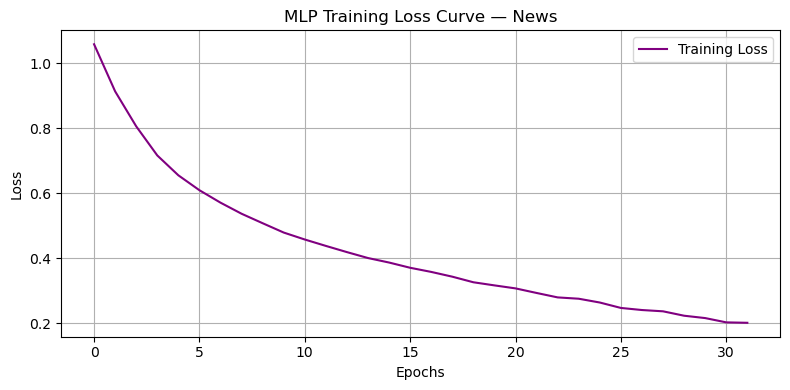

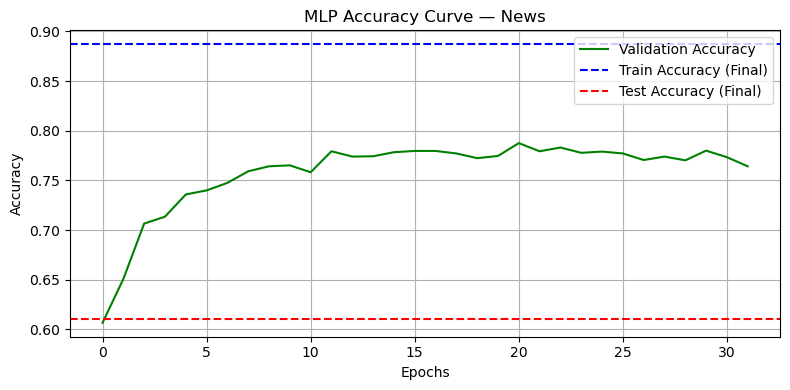

In [36]:
# Loss curve
plt.figure(figsize=(8, 4))
plt.plot(mlp.loss_curve_, label='Training Loss', color='purple')
plt.title('MLP Training Loss Curve — News')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("images/news_popularity/algorithms/mlp_loss_curve.png")
plt.show()

# Accuracy Curve (train and validation)
val_scores = mlp.validation_scores_

train_acc = accuracy_score(y_train_news, mlp.predict(X_train_news))
test_acc = accuracy_score(y_test_news, mlp.predict(X_test_news))

plt.figure(figsize=(8, 4))
plt.plot(val_scores, label='Validation Accuracy', color='green')
plt.axhline(y=train_acc, color='blue', linestyle='--', label='Train Accuracy (Final)')
plt.axhline(y=test_acc, color='red', linestyle='--', label='Test Accuracy (Final)')
plt.title('MLP Accuracy Curve — News')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("images/news_popularity/algorithms/mlp_accuracy_curve.png")
plt.show()


## Compare

In [37]:
results = pd.DataFrame({
    "Method": ["dt", "rf", "lr", "mlp"],
    "Accuracy-AIR": [accuracy_dt_air, accuracy_rf_air, accuracy_logreg_air, accuracy_mlp_air],
    "Accuracy-NEWS": [accuracy_dt_news, accuracy_rf_news, accuracy_logreg_news, accuracy_mlp_news]
})

print(results)

  Method  Accuracy-AIR  Accuracy-NEWS
0     dt      0.888557       0.813470
1     rf      0.892180       0.813470
2     lr      0.695291       0.477992
3    mlp      0.970381       0.610165
